# **Importing Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectPercentile
from sklearn.multiclass import OneVsRestClassifier

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.utils.multiclass import type_of_target
import re

import warnings
warnings.filterwarnings('ignore')

# Importing Data

In [2]:
train = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
test = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')

In [3]:
print('TRAIN DATA:', train.shape)
print('TEST DATA:', test.shape)

TRAIN DATA: (13636, 15)
TEST DATA: (4546, 14)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4546 entries, 0 to 4545
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 4546 non-null   int64 
 1   RecipeNumber       4546 non-null   int64 
 2   RecipeCode         4546 non-null   int64 
 3   RecipeName         4546 non-null   object
 4   CommentID          4546 non-null   object
 5   UserID             4546 non-null   object
 6   UserName           4546 non-null   object
 7   UserReputation     4546 non-null   int64 
 8   CreationTimestamp  4546 non-null   int64 
 9   ReplyCount         4546 non-null   int64 
 10  ThumbsUpCount      4546 non-null   int64 
 11  ThumbsDownCount    4546 non-null   int64 
 12  BestScore          4546 non-null   int64 
 13  Recipe_Review      4546 non-null   object
dtypes: int64(9), object(5)
memory usage: 497.3+ KB


In [6]:
train.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

There are two null values in the 'Recipe_Review' column

# **Exploratary Data Analysis**

In [7]:
train.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4546 entries, 0 to 4545
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 4546 non-null   int64 
 1   RecipeNumber       4546 non-null   int64 
 2   RecipeCode         4546 non-null   int64 
 3   RecipeName         4546 non-null   object
 4   CommentID          4546 non-null   object
 5   UserID             4546 non-null   object
 6   UserName           4546 non-null   object
 7   UserReputation     4546 non-null   int64 
 8   CreationTimestamp  4546 non-null   int64 
 9   ReplyCount         4546 non-null   int64 
 10  ThumbsUpCount      4546 non-null   int64 
 11  ThumbsDownCount    4546 non-null   int64 
 12  BestScore          4546 non-null   int64 
 13  Recipe_Review      4546 non-null   object
dtypes: int64(9), object(5)
memory usage: 497.3+ KB


In [10]:
train.describe() # Statistical info about numerical columns in training data

,ID,RecipeNumber,RecipeCode,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore
count,13636.000000,13636.000000,13636.000000,13636.000000,1.363600e+04,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000
mean,121.085289,38.624377,21785.990833,2.160311,1.623713e+09,0.014520,1.098269,0.543708,4.288721,153.127897
std,116.995633,29.672351,23883.189918,10.086424,5.444020e+06,0.137323,4.166487,3.265660,1.544839,140.986908
min,0.000000,1.000000,386.000000,0.000000,1.613035e+09,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,12.000000,6504.000000,1.000000,1.622717e+09,0.000000,0.000000,0.000000,5.000000,100.000000
50%,91.000000,33.000000,14600.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
75%,148.000000,63.000000,33121.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
max,724.000000,100.000000,191775.000000,510.000000,1.665756e+09,3.000000,80.000000,126.000000,5.000000,946.000000


## Dealing with missing data

In [11]:
train.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

In [12]:
train.fillna('', inplace = True)  # filling up the null values with space

In [13]:
train.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        0
dtype: int64

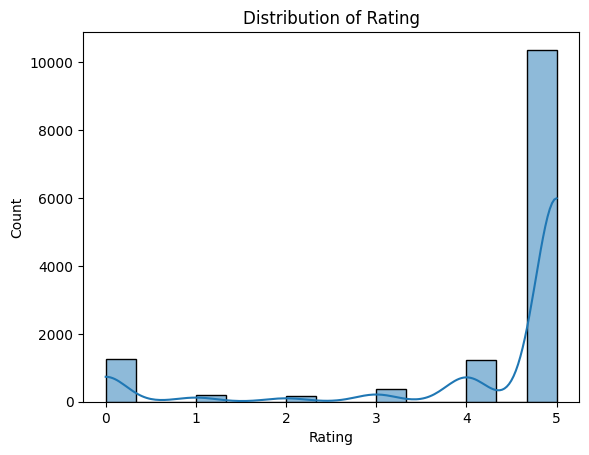

In [14]:
sns.histplot(train['Rating'], kde = True)
plt.title('Distribution of Rating');

It is shown in the above graph Rating 5 is the most frequent the the train data, looks like the data is imbalance

In [15]:
percentage = train['Rating'].value_counts(normalize = True)*100
percentage

Rating
5    76.056028
0     9.328249
4     9.100909
3     2.698739
1     1.540041
2     1.276034
Name: proportion, dtype: float64

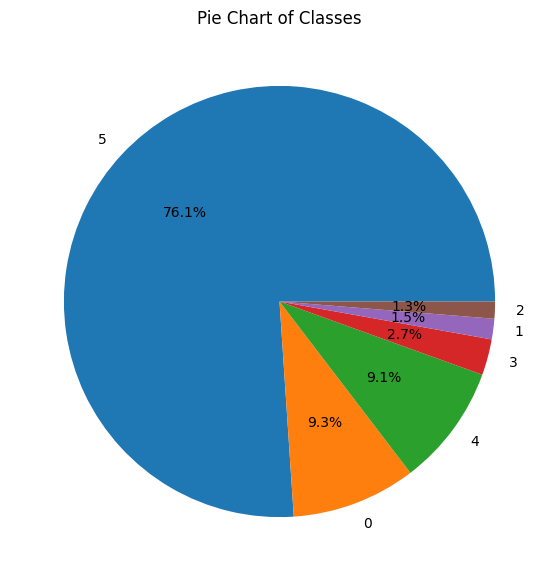

In [16]:
percentage = train['Rating'].value_counts(normalize = True)*100

classlabel = [5,0,4,3,1,2]
plt.figure(figsize = (12,7))
plt.pie(percentage, labels = classlabel, autopct = '%1.1f%%')
plt.title('Pie Chart of Classes')
plt.show()


Rating 5 is the highest in the dataset with 76.1%, followed by rating 0 with 9.3% and remaining counts up to 13 - 14 %

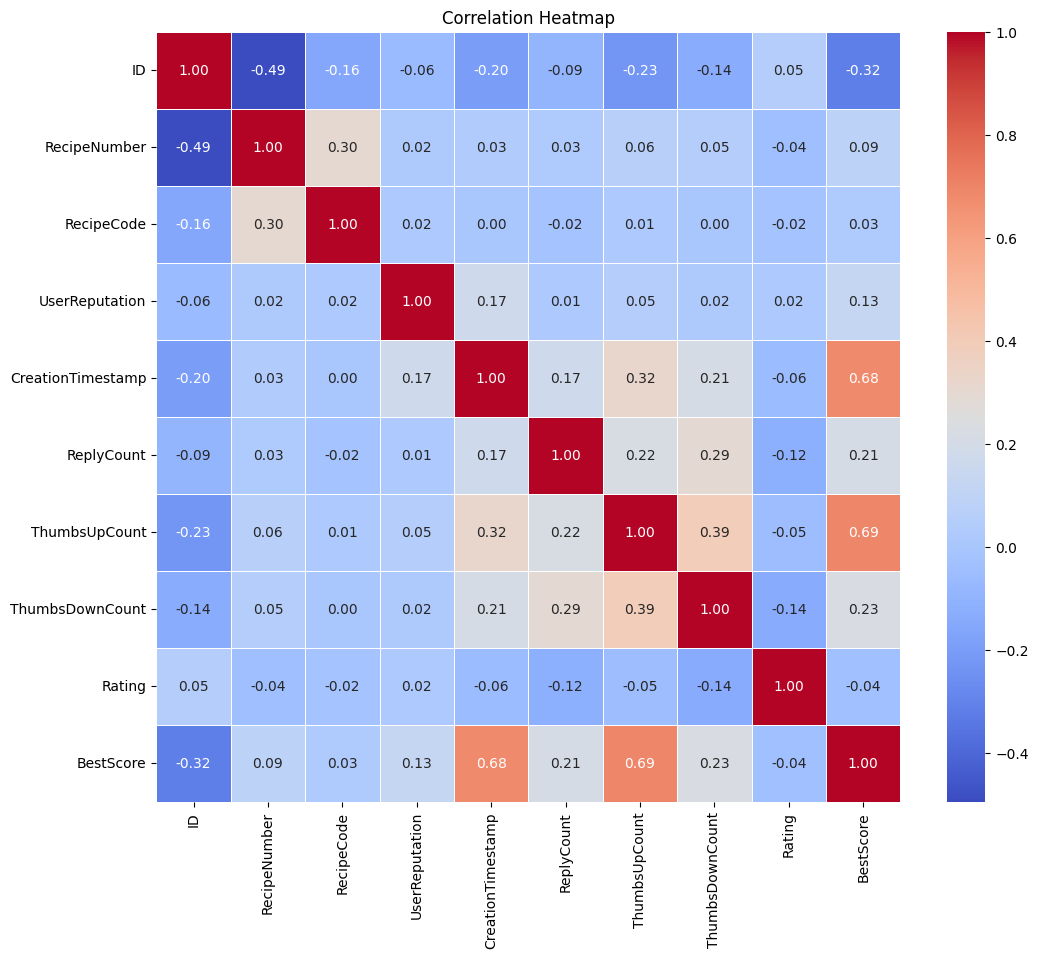

In [17]:
# Corelation matrix
correlation_matrix = train.corr(numeric_only = True)

plt.figure(figsize = (12,10))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidths = 0.5)
plt.title('Correlation Heatmap');

In the above figure Heatmap of train data is shown

it is looks like only BestScore-CreationTimestamp and BestScore-ThumbsUpCount are strongly correlated.

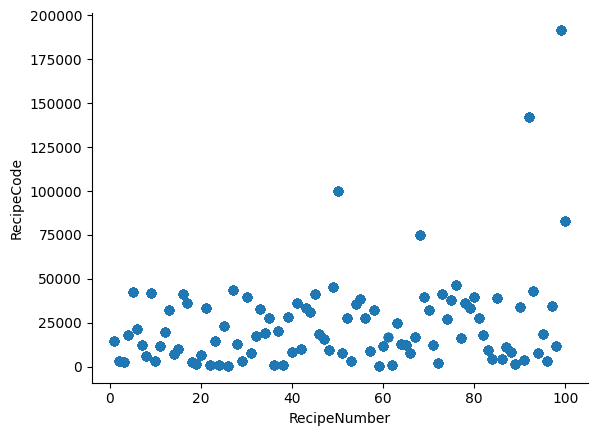

In [18]:
train.plot(kind='scatter', x='RecipeNumber', y='RecipeCode', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

shows the corelation between Recipecode and RecipeNumber

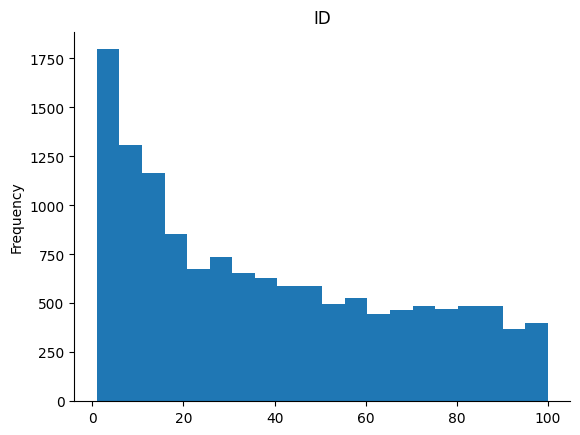

In [19]:
train['RecipeNumber'].plot(kind='hist', bins=20, title='ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

RecipeNumber is a Placement of the recipe on the top 100 recipes list.
In the above plot it is visible that recepie number from 0 - 20 is most frequent

# Data Processing

In [20]:
# Dropping unnecessary columns

train = train.drop(['ID', 'RecipeNumber', 'RecipeCode', 'CommentID', 'UserReputation', 'ReplyCount', 'BestScore','UserName','CreationTimestamp'], axis = 1)
test = test.drop(['ID', 'RecipeNumber', 'RecipeCode', 'CommentID', 'UserReputation', 'ReplyCount', 'BestScore','UserName','CreationTimestamp'], axis = 1)

Removed ['ID', 'RecipeNumber', 'RecipeCode', 'CommentID', 'UserReputation', 'ReplyCount', 'BestScore','UserName','CreationTimestamp'] columns from train and test as the values of these columns are missleading and not helping towards getting good accuracy

In [21]:
labels = train['Rating']
train = train.drop('Rating', axis = 1)

In [22]:
type_of_target(labels)

'multiclass'

The given probelm is a multiclass classification problem with rating values 0,1,2,3,4,5

In [23]:
train.head()

,RecipeName,UserID,ThumbsUpCount,ThumbsDownCount,Recipe_Review
0,Banana Bars with Cream Cheese Frosting,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,0,0,great recipe! I have made them just as written...
1,Simple Taco Soup,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,0,1,This is an easy and quick recipe that is great...
2,Cheeseburger Soup,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,0,0,I think I was looking for something extra spec...
3,Grilled Huli Huli Chicken,u_1oKZCQcKQZdQhDVBS7oISc216VA,0,0,This is our favorite grilled chicken recipe. ...
4,Cauliflower Soup,u_1oKd4sudZQPgu6YALiC7bW7mKMs,0,0,Great basic recipe. I added 2 teaspoons Tuscan...


## Split data into train and validation

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.20, random_state=69)

keeping the 20% data for validation of ml models

In [25]:
print('X_train data',X_train.shape)
print('X_test data',X_test.shape)

X_train data (10908, 5)
X_test data (2728, 5)


In [26]:
data1 = X_train.copy()    # copying the data so while preprocessing original data do not gt lost

In [27]:
arraytodf = lambda x: pd.DataFrame(x, columns = X_train.columns)
data1 = arraytodf(data1)

In [28]:
data1.head()

,RecipeName,UserID,ThumbsUpCount,ThumbsDownCount,Recipe_Review
5469,Chicken Wild Rice Soup,u_1oKVhJZY0eDWa7D2XDNiYnNJLUb,0,0,"Love this soup, but I add frozen chopped spina..."
5027,Basic Homemade Bread,u_1oKcl1gTWWrvSCCknCpCp7e8t9j,0,0,To anyone who has trouble making bread where i...
6331,Winning Apple Crisp,u_1oKVc0MrfoJNPHNy3ewx0RQcJpo,0,0,best crisp recipe I have tried....increased am...
1492,Creamy White Chili,u_1oKapC5Xuxk03NqL6WU2hkVsivR,1,0,This is a wonderfully rich and creamy chili th...
11396,Cheeseburger Soup,u_1oKVaKzorMbUpBVlR2AbR1HvYIT,0,0,Absolutely Fantastic!! Followed the recipe exa...


In [29]:
arraytodf = lambda x: pd.DataFrame(x, columns = X_train.columns)

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('arraytodf', FunctionTransformer(arraytodf))
])

Text(0.5, 0, '$\\chi^2$')

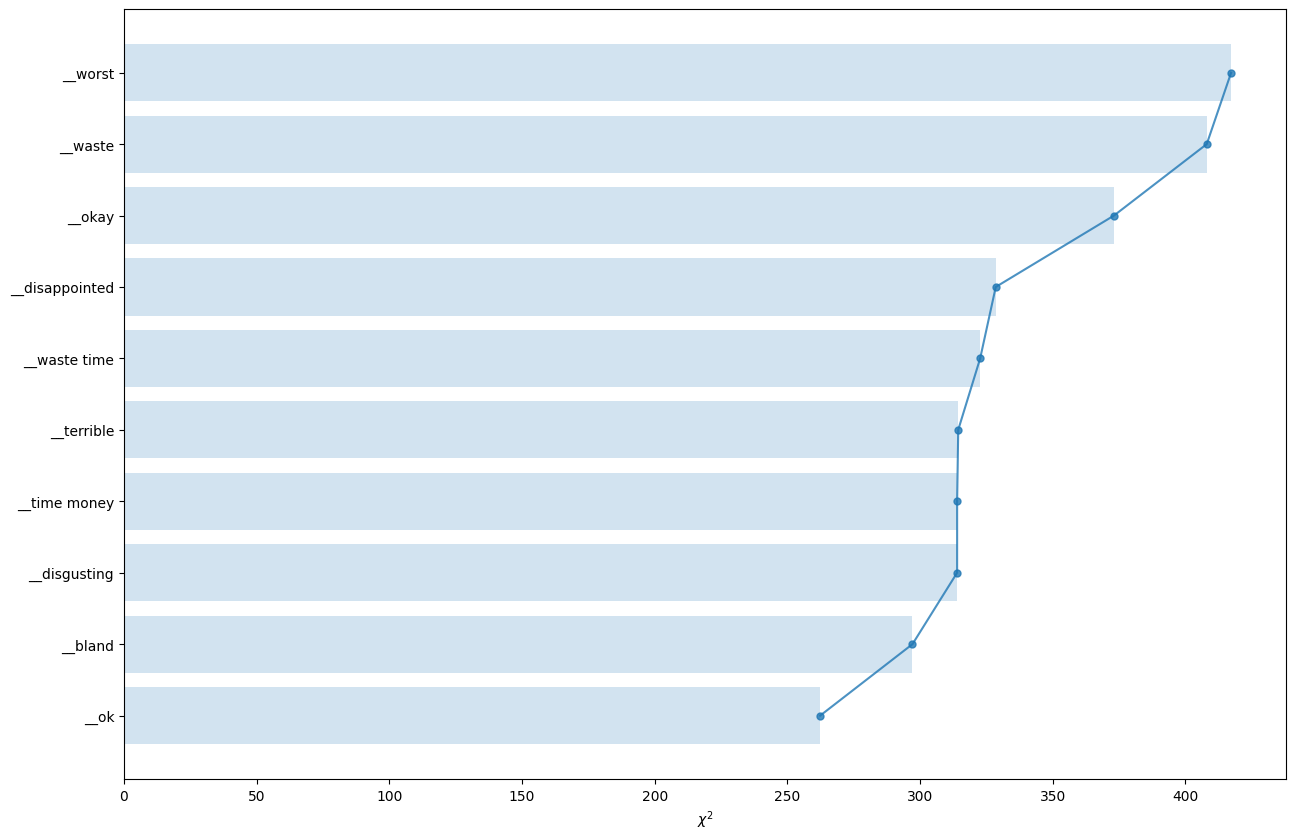

In [30]:
vect = CountVectorizer(binary=True, stop_words='english', ngram_range=(1,2))

count_trans = ColumnTransformer([
    ('',vect, 'Recipe_Review')
])
data_vec = count_trans.fit_transform(data1)
# print(data_vec.shape)

chi2score = chi2(data_vec, y_train)[0]

plt.figure(figsize=(15,10))
wscores = zip(count_trans.get_feature_names_out(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-10:]))
x = range(len(topchi2[1]))
label = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, label)
plt.xlabel('$\chi^2$')

Top 10 words from the recepie review column

In [34]:
X_train_pipe = pipe.fit_transform(X_train)
X_test_pipe = pipe.transform(X_test)

In [35]:
print(X_train_pipe.shape, X_test_pipe.shape)

(10908, 5) (2728, 5)


In [36]:
# categorical features transformation
vectorizer = TfidfVectorizer()

categorical_transformation = ColumnTransformer([
    ('review_vect',vectorizer, 'Recipe_Review'),
    ('name_vect',vectorizer, 'RecipeName'),
    ('ID_vect',vectorizer, 'UserID')
])

In [37]:
# Numerical Features Transformation

scaler = StandardScaler()

numerical_transformation = ColumnTransformer([
    ('scaling', scaler, ['ThumbsUpCount', 'ThumbsDownCount'])
])

In [38]:
data_transformer = FeatureUnion([
    ('categorical_transformer', categorical_transformation),
    ('numerical_transformer', numerical_transformation)
])

In [39]:
print(X_train_pipe.shape, X_test_pipe.shape)

(10908, 5) (2728, 5)


In [40]:
X_train_trans = data_transformer.fit_transform(X_train_pipe)
X_test_trans = data_transformer.transform(X_test_pipe)

In [41]:
# feature_sele = SelectFromModel(estimator = RidgeClassifier())

# X_train_trans = feature_sele.fit_transform(X_train_trans, y_train)
# X_test_trans = feature_sele.transform(X_test_trans)

Tried applying feature selection but the accuracy I got was lower(0.788) than expected.

In [42]:
X_train_trans.shape, X_test_trans.shape

((10908, 18487), (2728, 18487))

# Model Training

In [43]:
# Creating a function to evaluate the results


cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=123)

def evaluate(y_test, pred):
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred),3)*100))
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(y_test, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))

## Logistic Regression

In [44]:
logreg = LogisticRegression(max_iter = 2000)

logreg_cv_score = cross_validate(logreg, X_train_trans, y_train, cv = cv, n_jobs = -1, verbose = 0, scoring='accuracy', return_train_score=True)
pd.DataFrame(logreg_cv_score, columns = ['train_score','test_score'])

,train_score,test_score
0,0.889182,0.774977
1,0.889984,0.777269
2,0.888494,0.776352


* The LogisticRegression model is likely to be OVERFITTING on train data
* I will apply **Regularization** on the model to reduce overfitting.


In [45]:
# parameter tunning of model
logreg = LogisticRegression(max_iter=3000)

params = {'solver': ['liblinear','newton-cg','sag', 'lbfgs'],
          'max_iter':[1000,2000]},

grid_search_log_reg = GridSearchCV(logreg, params, n_jobs=-1, verbose=1, cv=cv, scoring='accuracy', return_train_score=True)
grid_search_log_reg.fit(X_train_trans, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=123, test_size=0.2,
            train_size=None),
             estimator=LogisticRegression(max_iter=3000), n_jobs=-1,
             param_grid=({'max_iter': [1000, 2000],
                          'solver': ['liblinear', 'newton-cg', 'sag',
                                     'lbfgs']},),
             return_train_score=True, scoring='accuracy', verbose=1)

In [46]:
pd.DataFrame(grid_search_log_reg.cv_results_, columns=['params','mean_fit_time','mean_test_score','mean_train_score','rank_test_score']).sort_values(by='rank_test_score').set_index('params').head()

,mean_fit_time,mean_test_score,mean_train_score,rank_test_score
params,,,,
"{'max_iter': 1000, 'solver': 'sag'}",29.026983,0.776658,0.888762,1
"{'max_iter': 1000, 'solver': 'newton-cg'}",3.443915,0.776199,0.889296,2
"{'max_iter': 1000, 'solver': 'lbfgs'}",4.961114,0.776199,0.889220,2
"{'max_iter': 2000, 'solver': 'newton-cg'}",3.056617,0.776199,0.889296,2
"{'max_iter': 2000, 'solver': 'lbfgs'}",4.987639,0.776199,0.889220,2


* All the Solvers performed equally with score with regularization parameter value **C=1** and **penalty='l2'**
* But with respect to time taken for fitting the model the **'lbfgs'** solver gives best results.

In [47]:
lr = LogisticRegression(max_iter=1000, penalty='l2', C=1, solver='lbfgs')
lr.fit(X_train_trans, y_train)
pred = lr.predict(X_test_trans)

evaluate(y_test, pred)

Accuracy = 77.3%

 Confusiton Matrix:
 [[  50    2    0    3    7  215]
 [   5    4    3    0    2   25]
 [   2    2    0    4    6   21]
 [   3    3    1    5   16   47]
 [   4    0    2    2   24  212]
 [  10    0    0    1   20 2027]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.18      0.28       277
           1       0.36      0.10      0.16        39
           2       0.00      0.00      0.00        35
           3       0.33      0.07      0.11        75
           4       0.32      0.10      0.15       244
           5       0.80      0.98      0.88      2058

    accuracy                           0.77      2728
   macro avg       0.41      0.24      0.26      2728
weighted avg       0.71      0.77      0.71      2728



### Roc Curve for logistic regression

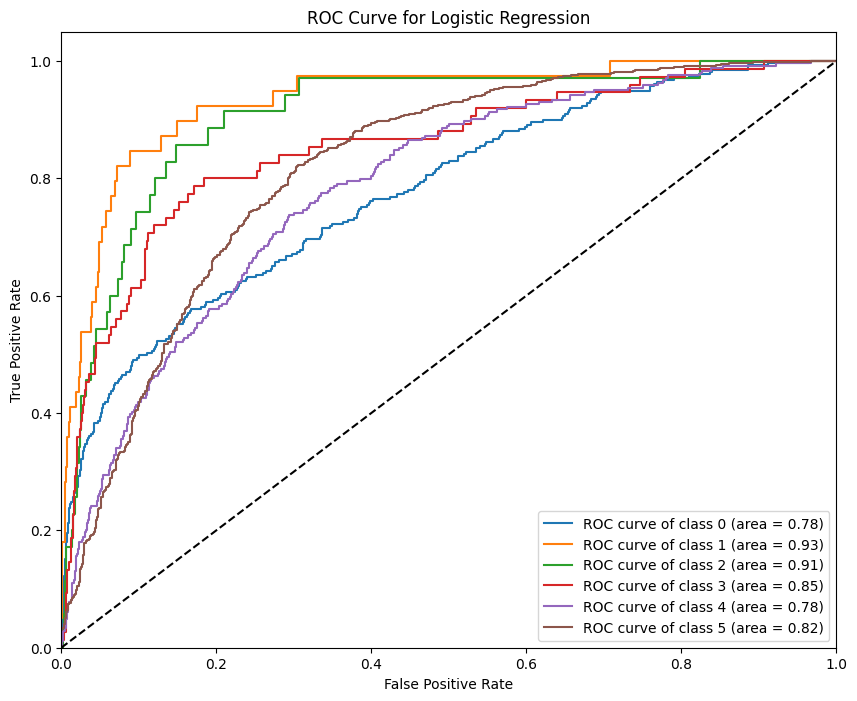

In [48]:
ovr_clf = OneVsRestClassifier(lr)
ovr_clf.fit(X_train_trans, y_train)  # applying ovr on x_train

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = ovr_clf.decision_function(X_test_trans)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

## LinearSVC

In [49]:
linear_svc = LinearSVC(max_iter=3000)

cv_scores_svm = cross_validate(linear_svc, X_train_trans, y_train, cv=cv, n_jobs=-1, verbose=0, scoring='f1_micro', return_train_score=True)
pd.DataFrame(cv_scores_svm, columns=['train_score','test_score'])

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,train_score,test_score
0,0.998854,0.770394
1,0.998969,0.775435
2,0.998510,0.771769


Hyperparameter tuining is required for linear SVC also

In [50]:
linear_svc = LinearSVC()

params = [{'penalty': ['l2'], 'C': [0.01, 0.1,1], 'loss':['hinge','squared_hinge'], 'max_iter':[1000, 1500]},
          {'penalty':['l1'], 'C': [0.01, 0.1,1], 'loss': ['squared_hinge'], 'max_iter': [1000, 1500]}]

grid_search_svm = GridSearchCV(linear_svc, params, n_jobs=-1, verbose=1, cv=cv, scoring='accuracy')
grid_search_svm.fit(X_train_trans, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=123, test_size=0.2,
            train_size=None),
             estimator=LinearSVC(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1],
                          'loss': ['hinge', 'squared_hinge'],
                          'max_iter': [1000, 1500], 'penalty': ['l2']},
                         {'C': [0.01, 0.1, 1], 'loss': ['squared_hinge'],
                          'max_iter': [1000, 1500], 'penalty': ['l1']}],
             scoring='accuracy', verbose=1)

In [51]:
grid_search_svm.best_params_

{'C': 1, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}

In [52]:
pd.DataFrame(grid_search_svm.cv_results_, columns=['params','mean_fit_time','mean_test_score','mean_train_score','rank_test_score']).sort_values(by='rank_test_score').set_index('params').head()

,mean_fit_time,mean_test_score,mean_train_score,rank_test_score
params,,,,
"{'C': 1, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}",5.668842,0.774977,NaN,1
"{'C': 1, 'loss': 'hinge', 'max_iter': 1500, 'penalty': 'l2'}",8.027049,0.774672,NaN,2
"{'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}",10.270485,0.772686,NaN,3
"{'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 1500, 'penalty': 'l2'}",14.204849,0.772533,NaN,4
"{'C': 1, 'loss': 'squared_hinge', 'max_iter': 1500, 'penalty': 'l2'}",9.165747,0.772533,NaN,5


Best parameters we got are {'C': 1, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'} we will use this parameters for training.

In [53]:
linear_svc = LinearSVC(C=1, loss='squared_hinge', penalty='l2', max_iter=1000)
linear_svc.fit(X_train_trans, y_train)
pred = linear_svc.predict(X_test_trans)

evaluate(y_test, pred)

Accuracy = 77.8%

 Confusiton Matrix:
 [[  66    2    0    5   12  192]
 [   6    7    6    1    4   15]
 [   1    4    5    5    8   12]
 [   5    3    3    7   19   38]
 [   8    0    3    3   47  183]
 [  21    0    0    3   43 1991]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.24      0.34       277
           1       0.44      0.18      0.25        39
           2       0.29      0.14      0.19        35
           3       0.29      0.09      0.14        75
           4       0.35      0.19      0.25       244
           5       0.82      0.97      0.89      2058

    accuracy                           0.78      2728
   macro avg       0.47      0.30      0.34      2728
weighted avg       0.73      0.78      0.74      2728



### Roc Curve for LinearSVC

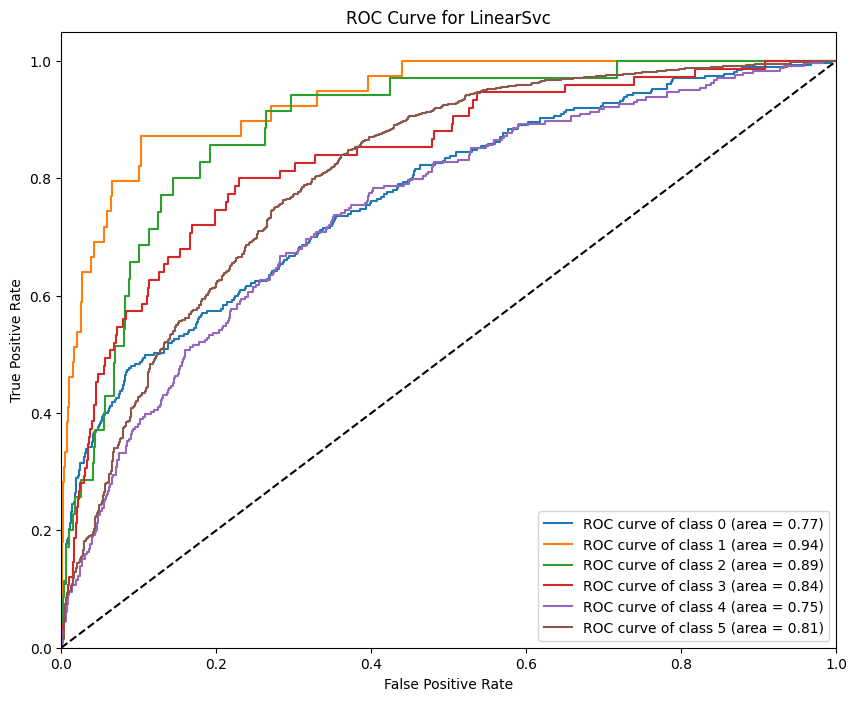

In [54]:
ovr_clf = OneVsRestClassifier(linear_svc)
ovr_clf.fit(X_train_trans, y_train)  # applying ovr on x_train

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = ovr_clf.decision_function(X_test_trans)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LinearSvc')
plt.legend(loc="lower right")
plt.show()

## XGBoost


In [55]:
xgb = XGBClassifier(max_depth=80, n_jobs=-1)

cv_scores_xgb = cross_validate(xgb, X_train_trans, y_train, cv=cv, n_jobs=-1, scoring='f1_micro',return_train_score=True)
pd.DataFrame(cv_scores_xgb, columns=['train_score','test_score'])

,train_score,test_score
0,0.999771,0.773144
1,0.999885,0.774060
2,0.999656,0.779102


Train score is far better than test score classic case of overfitting, Hyperparameter tuining is required.

In [56]:
xgb = XGBClassifier(n_jobs=-1)

params = {
    'max_depth': [60,100],  # Test different maxdepth
}

grid_search_xgb = GridSearchCV(xgb, params, n_jobs=-1, verbose=1, cv=cv, scoring='f1_micro')
grid_search_xgb.fit(X_train_trans, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=123, test_size=0.2,
            train_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_p...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1, param_grid={'max_depth': [60, 100]}, scoring='f1_micro',
             verbose=1)

In [57]:
pd.DataFrame(grid_search_xgb.cv_results_, columns=['params','mean_fit_time','mean_test_score','mean_train_score','rank_test_score']).sort_values(by='rank_test_score').set_index('params').head()

,mean_fit_time,mean_test_score,mean_train_score,rank_test_score
params,,,,
{'max_depth': 100},325.129853,0.773755,NaN,1
{'max_depth': 60},418.702089,0.772838,NaN,2


max depth of 80 is giving better results

In [58]:
xgb = XGBClassifier(max_depth = 80, n_jobs = -1)

xgb.fit(X_train_trans, y_train)
y_pred = xgb.predict(X_test_trans)

evaluate(y_test, y_pred)

Accuracy = 77.10000000000001%

 Confusiton Matrix:
 [[  54    4    0    4    7  208]
 [   4    7    1    1    3   23]
 [   2    3    2    3    8   17]
 [   4    6    2    5    9   49]
 [   8    0    3    0   18  215]
 [  18    2    0    1   21 2016]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.19      0.29       277
           1       0.32      0.18      0.23        39
           2       0.25      0.06      0.09        35
           3       0.36      0.07      0.11        75
           4       0.27      0.07      0.12       244
           5       0.80      0.98      0.88      2058

    accuracy                           0.77      2728
   macro avg       0.43      0.26      0.29      2728
weighted avg       0.70      0.77      0.71      2728



### Roc Curve For XGBClassifier 

In [62]:

# xgb_classifier = XGBClassifier(objective='binary:logistic', num_class=len(np.unique(y_train)))

# ovr_clf = OneVsRestClassifier(xgb_classifier)

# ovr_clf.fit(X_train_trans, y_train)

# y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# y_score = ovr_clf.predict_proba(X_test_trans)

# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(len(np.unique(y_test))):
#     fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curve for each class
# plt.figure(figsize=(10, 8))
# for i in range(len(np.unique(y_test))):
#     plt.plot(fpr[i], tpr[i], label='ROC curve of class {} (area = {:.2f})'.format(i, roc_auc[i]))

# plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line for reference
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for XGBoost with OneVsRestClassifier')
# plt.legend(loc="lower right")
# plt.show()


## Light Gradient Boost

In [63]:
lgbm  = LGBMClassifier(max_depth = 20)

cv_scores_ridge = cross_validate(lgbm, X_train_trans, y_train, cv=cv, n_jobs=-1, verbose=0, scoring='f1_micro', return_train_score=True)
pd.DataFrame(cv_scores_ridge, columns=['train_score','test_score'])

,train_score,test_score
0,0.961838,0.767644
1,0.961724,0.780477
2,0.961265,0.773144


Hyperparameter tuining for Light Gradient Boost

In [64]:
lgbm  = LGBMClassifier(max_depth = 20)

params = {
      'max_depth':[20,30,40]  # Test different maxdepth
}

grid_search_lgbm = GridSearchCV(lgbm, params, n_jobs=-1, verbose=1, cv=cv, scoring='f1_micro')
grid_search_lgbm.fit(X_train_trans, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=123, test_size=0.2,
            train_size=None),
             estimator=LGBMClassifier(max_depth=20), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40]}, scoring='f1_micro',
             verbose=1)

In [65]:
pd.DataFrame(grid_search_lgbm.cv_results_, columns=['params','mean_fit_time','mean_test_score','mean_train_score','rank_test_score']).sort_values(by='rank_test_score').set_index('params').head()

,mean_fit_time,mean_test_score,mean_train_score,rank_test_score
params,,,,
{'max_depth': 30},68.587034,0.776505,NaN,1
{'max_depth': 40},51.267418,0.776505,NaN,1
{'max_depth': 20},64.385502,0.773755,NaN,3


will go with default parameter with max_depth = 20

In [66]:
lgbm  = LGBMClassifier(max_depth = 20)

lgbm.fit(X_train_trans, y_train)
y_pred = lgbm.predict(X_test_trans)

evaluate(y_test, y_pred)

Accuracy = 77.4%

 Confusiton Matrix:
 [[  49    4    0    3   14  207]
 [   8    3    0    1    2   25]
 [   2    2    3    5   11   12]
 [   4    3    2    7    9   50]
 [   6    0    1    2   30  205]
 [  13    0    0    0   25 2020]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.18      0.27       277
           1       0.25      0.08      0.12        39
           2       0.50      0.09      0.15        35
           3       0.39      0.09      0.15        75
           4       0.33      0.12      0.18       244
           5       0.80      0.98      0.88      2058

    accuracy                           0.77      2728
   macro avg       0.48      0.26      0.29      2728
weighted avg       0.72      0.77      0.72      2728



### Roc Curve for LightBGM

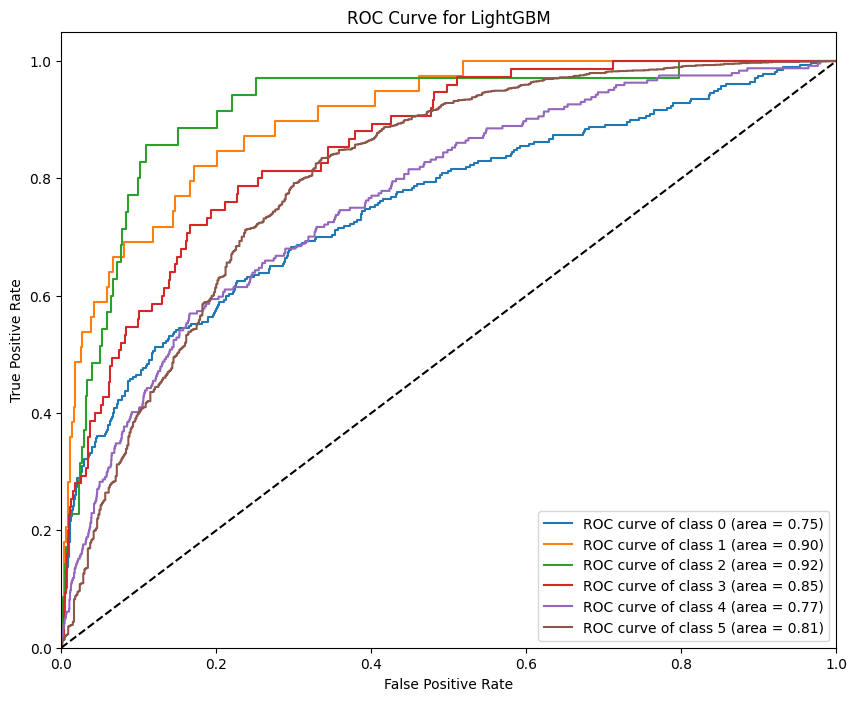

In [67]:
ovr_clf = OneVsRestClassifier(lgbm)
ovr_clf.fit(X_train_trans, y_train)  # applying ovr on x_train

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_prob = ovr_clf.predict_proba(X_test_trans)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM')
plt.legend(loc="lower right")
plt.show()

From above 4 models xgboost, lgbmClassifier, LinearSvc gave us satisfying results,
We will use aggreator with these three classifiers to boost up the accuracy

## Vooting Classifier

In [68]:
estimators = [('lightgbm', LGBMClassifier(max_depth = 21)),
              ('svm', LinearSVC(C=1, loss='squared_hinge', penalty='l2', max_iter=1000)),
              ('xgb', XGBClassifier(max_depth=80))]

votingclf = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1, verbose=1)

vooting_cv_scoresvote = cross_validate(votingclf, X_train_trans, y_train, cv=cv, n_jobs=-1, verbose=0, scoring='f1_micro', return_train_score=True)
pd.DataFrame(vooting_cv_scoresvote, columns=['train_score','test_score'])

[Voting] ................. (1 of 3) Processing lightgbm, total=  14.9s
[Voting] ...................... (2 of 3) Processing svm, total=   4.8s
[Voting] ...................... (3 of 3) Processing xgb, total= 4.5min
[Voting] ................. (1 of 3) Processing lightgbm, total=  15.6s
[Voting] ...................... (2 of 3) Processing svm, total=   4.6s
[Voting] ...................... (3 of 3) Processing xgb, total= 4.3min
[Voting] ................. (1 of 3) Processing lightgbm, total=  13.6s
[Voting] ...................... (2 of 3) Processing svm, total=   4.7s
[Voting] ...................... (3 of 3) Processing xgb, total= 4.5min


,train_score,test_score
0,0.999083,0.778185
1,0.999656,0.781852
2,0.999198,0.781393


# Training on Complete Dataset

In [70]:
model_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('arraytodf', FunctionTransformer(arraytodf))
])

In [71]:
train = model_pipe.fit_transform(train)
test = model_pipe.transform(test)

In [72]:
train_trans = data_transformer.fit_transform(train)
test_trans = data_transformer.transform(test)
print(train_trans.shape, test_trans.shape)

(13636, 21450) (4546, 21450)


In [73]:
# train_trans = feature_sele.fit_transform(train_trans, labels)
# test_trans = feature_sele.transform(test_trans)

In [74]:
model = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1, verbose=1)

In [75]:
model.fit(train_trans, labels)

[Voting] ................. (1 of 3) Processing lightgbm, total=  22.4s
[Voting] ...................... (2 of 3) Processing svm, total=   9.9s
[Voting] ...................... (3 of 3) Processing xgb, total= 8.9min


VotingClassifier(estimators=[('lightgbm', LGBMClassifier(max_depth=21)),
                             ('svm', LinearSVC(C=1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=N...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=80,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 n_jobs=-1, verbose=1)

In [76]:
model.score(train_trans, labels)

0.9975066001760047

# Submitting To Test Data

In [77]:
y_pred = model.predict(test_trans)

In [78]:
submission = pd.DataFrame({"ID": range(1,4547),
                           "Rating": y_pred})
submission.to_csv('submission.csv', index=False)

# Thank You!